In [1]:
import os

In [2]:
# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [3]:
from typing import List, Dict, Optional

import numpy as np
import pandas as pd

from scipy.signal import periodogram    
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from src.config import config_plotting
from src.config import periods

In [4]:
config_plotting("paper")

In [5]:
# Some Constants

In [6]:
tr = 2.0 # repetition time in seconds
sampling_rate = 1/tr # sampling rate in Hz

# Loading Feature Set

In [7]:
bert_feature_set = "data/bling_reading/featureset_en/timescales_BERT_all.npz"
mbert_feature_set = "data/bling_reading/featureset_en/timescales_mBERT_all.npz"

bert_features_meta = "data/bling_reading/featureset_en/timescales_BERT_all_train_meta.csv"
mbert_features_meta = "data/bling_reading/featureset_en/timescales_mBERT_all_train_meta.csv"

In [8]:
bert_features = np.load(bert_feature_set, allow_pickle=True)
bert_train_feature = bert_features["train"].tolist()

mbert_features = np.load(mbert_feature_set, allow_pickle=True)
mbert_train_feature = mbert_features["train"].tolist()

In [9]:
bert_meta = pd.read_csv(bert_features_meta, index_col=0)
mbert_meta = pd.read_csv(mbert_features_meta, index_col=0)

# Correlation 

In [10]:
bert_train_feature_fast = bert_train_feature["2_4_words"]
mbert_train_feature_fast = mbert_train_feature["2_4_words"]

bert_train_feature_slow = bert_train_feature["256+ words"]
mbert_train_feature_slow = mbert_train_feature["256+ words"]

In [11]:
# compute cosine similarity between vectors adjecent in time
# for each sentence, compute the cosine similarity between the current and the next vector

def get_correlations(
        bert_feature_time_series: np.ndarray,
        mbert_feature_time_series: np.ndarray,
        lags: list = [1,2,4,8,16,32]):

    correlations = []

    for lag in lags:
        bert_cosine_similarity = []

        for i in range(len(bert_feature_time_series)):
            if i == len(bert_feature_time_series)-lag:
                break
            else:
                bert_cosine_similarity.append(cosine_similarity(bert_feature_time_series[i].reshape(1, -1), bert_feature_time_series[i+lag].reshape(1, -1)))

        mbert_cosine_similarity = []

        for i in range(len(mbert_feature_time_series)):
            if i == len(mbert_feature_time_series)-lag:
                break
            else:
                mbert_cosine_similarity.append(cosine_similarity(mbert_feature_time_series[i].reshape(1, -1), mbert_feature_time_series[i+lag].reshape(1, -1)))

        bert_cosine_similarity = np.array(bert_cosine_similarity).ravel()
        mbert_cosine_similarity = np.array(mbert_cosine_similarity).ravel()

        # correlate cosine similarities
        corr = np.corrcoef(bert_cosine_similarity, mbert_cosine_similarity)[0, 1]

        correlations.append({
            'lag': lag,
            'correlation': corr,
            'bert_cosine_similarity': bert_cosine_similarity,
            'mbert_cosine_similarity': mbert_cosine_similarity})

    return pd.DataFrame(correlations)

In [12]:
correlations_fast = get_correlations(bert_train_feature_fast, mbert_train_feature_fast)
correlations_slow = get_correlations(bert_train_feature_slow, mbert_train_feature_slow) 

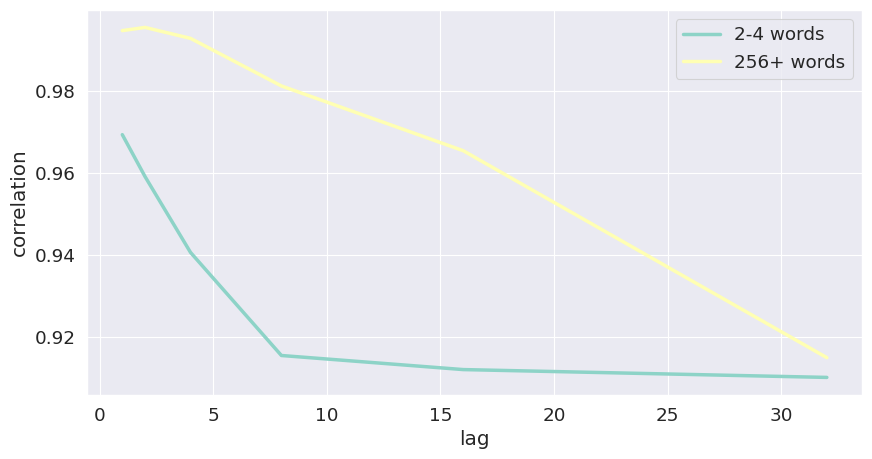

In [13]:
# plot bert vs mbert cosine similarity for different lags

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=correlations_fast, x="lag", y="correlation", ax=ax, label="2-4 words")
sns.lineplot(data=correlations_slow, x="lag", y="correlation", ax=ax, label="256+ words")

ax.set_xlabel("lag")
ax.set_ylabel("correlation")

plt.show()

In [14]:
# Fast

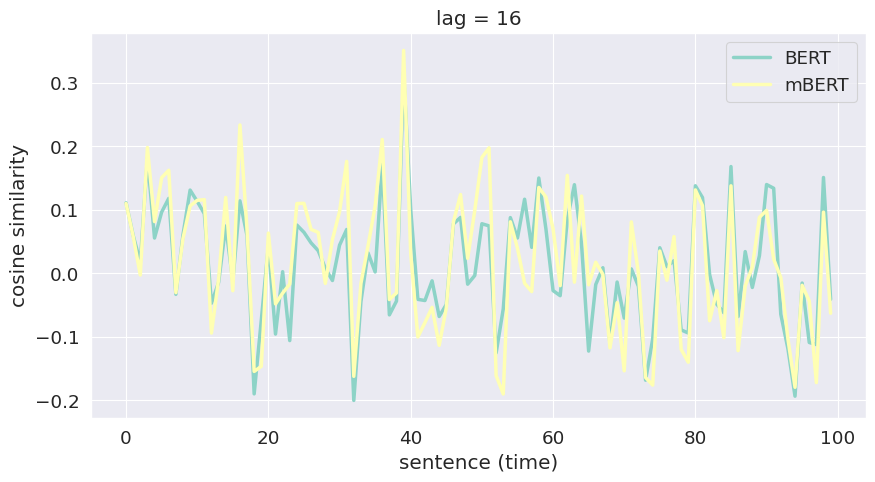

In [15]:
# plot lbert vs mbert cosine similarity time-serires of one of the lags
lag_idx = 4
max_len = 100

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    x=range(max_len),
    y=correlations_fast["bert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="BERT",
)
sns.lineplot(
    x=range(max_len),
    y=correlations_fast["mbert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="mBERT",
)

ax.set_xlabel("sentence (time)")
ax.set_ylabel("cosine similarity")

ax.set_title("lag = {}".format(correlations_fast["lag"][lag_idx]))

plt.show()

In [16]:
correlations_fast.head()

,lag,correlation,bert_cosine_similarity,mbert_cosine_similarity
0,1,0.969427,"[0.5687074678550835, 0.4252424638329324, 0.427...","[0.5189321243775824, 0.4413293830081819, 0.514..."
1,2,0.959196,"[-0.05338244682781635, 0.15512790122126255, 0....","[-0.07330028694983363, 0.20920134041584354, 0...."
2,4,0.940692,"[0.05715697656273283, 0.034413362516515764, -0...","[0.015341031483063046, 0.05454836687913138, -0..."
3,8,0.915525,"[-0.03651919848220353, 0.042538790878728965, -...","[-0.00808716230978066, 0.059243020893438254, -..."
4,16,0.912086,"[0.11107338446114082, 0.059575067597200076, 0....","[0.11003464709169318, 0.05830555713346101, -0...."


## Slow

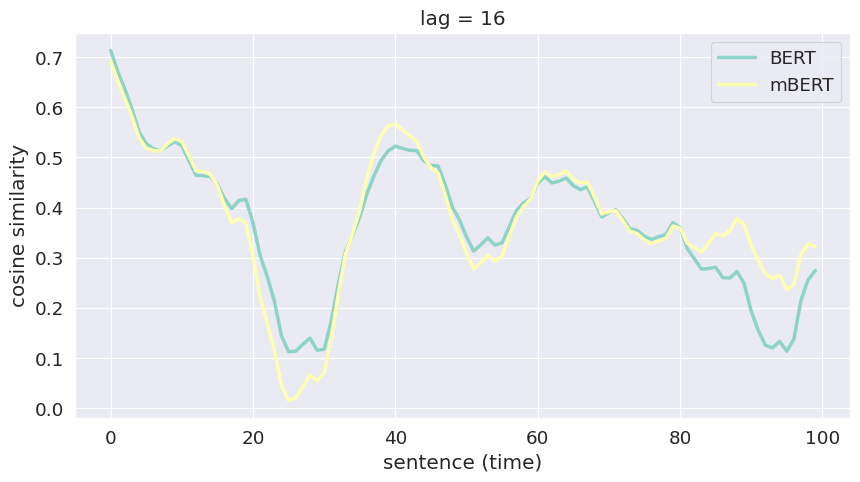

In [17]:
# plot lbert vs mbert cosine similarity time-serires of one of the lags
lag_idx = 4
max_len = 100

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    x=range(max_len),
    y=correlations_slow["bert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="BERT",
)
sns.lineplot(
    x=range(max_len),
    y=correlations_slow["mbert_cosine_similarity"][lag_idx][:max_len],
    ax=ax,
    label="mBERT",
)

ax.set_xlabel("sentence (time)")
ax.set_ylabel("cosine similarity")

ax.set_title("lag = {}".format(correlations_fast["lag"][lag_idx]))

plt.show()

In [18]:
correlations_slow.head()

,lag,correlation,bert_cosine_similarity,mbert_cosine_similarity
0,1,0.994825,"[0.999708689214601, 0.999481534010422, 0.99956...","[0.9994704540867505, 0.9993819954645023, 0.999..."
1,2,0.995608,"[0.9987217061730294, 0.9982186278728862, 0.998...","[0.9985280824012239, 0.9980332077614136, 0.998..."
2,4,0.992936,"[0.9947000917191196, 0.9934777721509468, 0.991...","[0.9938683359181173, 0.9927733467895897, 0.989..."
3,8,0.981323,"[0.9590241692156332, 0.9488938724346687, 0.940...","[0.9532178949419842, 0.943244177762644, 0.9332..."
4,16,0.965514,"[0.7133539834394549, 0.6709959757349451, 0.635...","[0.6919813120269251, 0.6530266676809756, 0.617..."


In [19]:
# PSD of the embeddings and cross-correlation
# use BERT embedding to fit EM 

# PSD Analysis

In [20]:
# function computing the PSD of a time-series
def compute_psd(
    feature_set: Dict,
    timescale: str,
    agg_method: str = "mean",
    sampling_rate: float = 0.5,
    fft_size: Optional[int] = None,
):
    """
    Compute the PSD of a feature set for a given timescale.

    Parameters
    ----------
    feature_set : Dict
        Dictionary containing the feature set.
    timescale : str
        Timescale of the feature set.
    agg_method : str
        Aggregation method to use for the PSD. Options are 'mean', 'max' or 'min'.

    Returns
    -------
    psd : np.ndarray
        PSD of the feature set for the given timescale.
    """
    feature = feature_set[timescale]
    n_feature = feature.shape[1]
    #n_feature=10
    ps = []
    f = []
    for i in tqdm(range(n_feature)):
        f, p = periodogram(feature[:,i], fs=sampling_rate, nfft=fft_size)

        ps.append(p)

    psd = np.vstack(ps)

    assert psd.shape[0] == n_feature
    if agg_method == "max":
        psd = np.max(psd, axis=0)
    elif agg_method == "min":
        psd = np.min(psd, axis=0)
    else:  # agg_method == 'mean':
        psd = np.mean(psd, axis=0)

    return {"f": f, "psd": psd}

In [21]:
def plot_psd(psd, periods, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    for p in periods:
        res = psd[p]

        sns.lineplot(x=res["f"][1:-1], y=res["psd"][1:-1], ax=ax, label=p)

    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("PSD")

    ax.legend()
    ax.set_yscale("log")

    return ax

In [22]:
psd_bert = {}
psd_mbert = {}
diff_psd = {}

for p in periods:
    res = compute_psd(
        bert_train_feature,
        p,
        agg_method="mean",
        sampling_rate=sampling_rate,
        fft_size=512,
    )
    psd_bert[p] = res

    res = compute_psd(
        mbert_train_feature,
        p,
        agg_method="mean",
        sampling_rate=sampling_rate,
        fft_size=512,
    )
    psd_mbert[p] = res

    res = np.abs(psd_bert[p]["psd"] - psd_mbert[p]["psd"])
    diff_psd[p] = {"f": psd_bert[p]["f"], "psd": res}

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

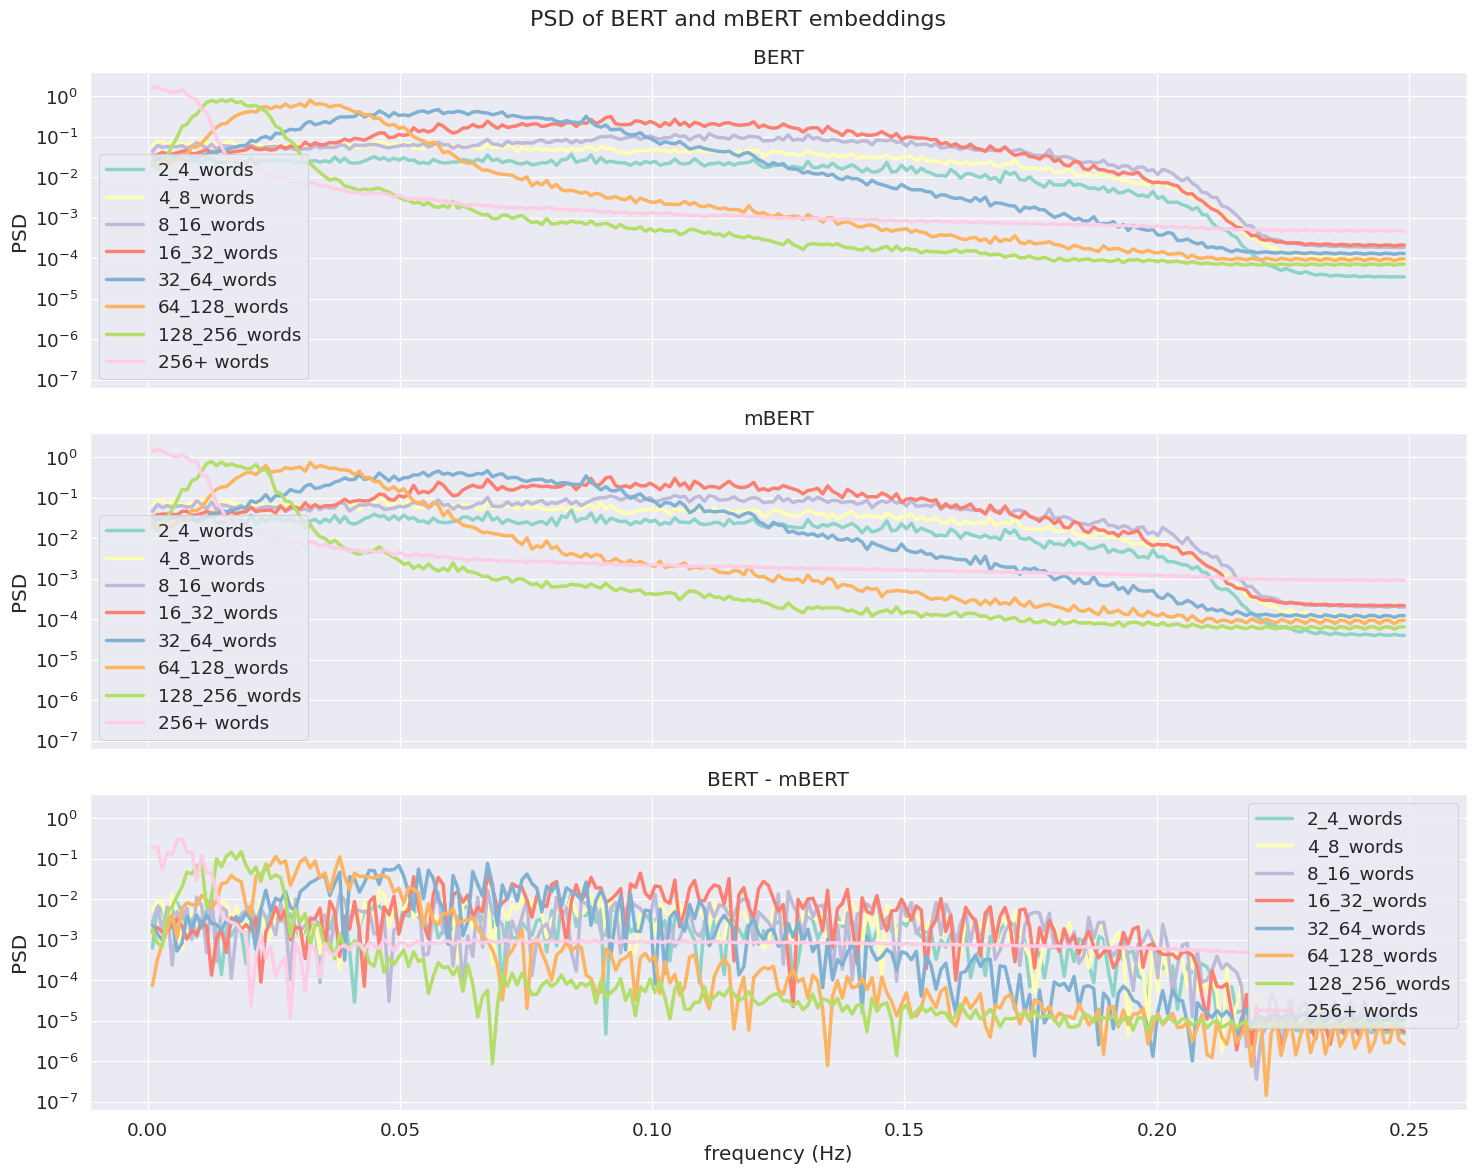

In [23]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharey=True, sharex=True)
axes = axes.ravel()

plot_psd(psd_bert, periods, ax=axes[0])
plot_psd(psd_mbert, periods, ax=axes[1])
plot_psd(diff_psd, periods, ax=axes[2])

axes[0].set_title("BERT")
axes[1].set_title("mBERT")
axes[2].set_title("BERT - mBERT")

fig.suptitle("PSD of BERT and mBERT embeddings", fontsize=16)

plt.tight_layout()
plt.show()


# Cross-Correlation Across Timescale Analysis

In [24]:
def compute_timescale_crosscorrelation(feature_set, periods, agg_method="mean"):
    """
    Compute the cross-correlation of the PSD of a feature set for a given timescale.

    Parameters
    ----------
    feature_set : Dict
        Dictionary containing the feature set.
    periods : list
        List of timescales of the feature set.
    agg_method : str
        Aggregation method to use. Options are 'mean', 'max' or 'min'.

    Returns
    -------
    crosscorr : np.ndarray
        Cross-correlation of the PSD of the feature set for the given timescale.
    """
    
    # aggregating over all features
    features = []
    for p in periods:
        if agg_method == "max":
            f = np.max(feature_set[p], axis=1)
        elif agg_method == "min":
            f = np.min(feature_set[p], axis=1)
        else:  # agg_method == 'mean':
            f = np.mean(feature_set[p], axis=1)
        features.append(f)

    # stack em up
    features = np.vstack(features)

    # compute cross-correlation across timescales
    crosscorr = np.corrcoef(features)

    return crosscorr

In [25]:
def plot_heatmap(crosscorr:np.ndarray, periods: List, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    mask = np.zeros_like(crosscorr)
    mask[np.triu_indices_from(mask, k=1)] = True

    sns.heatmap(
        crosscorr,
        ax=ax,
        vmin=-1,
        vmax=1,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        square=True,
        xticklabels=periods,
        yticklabels=periods,
        mask=mask,
    )

    return ax

In [26]:
bert_crosscorr_max = compute_timescale_crosscorrelation(bert_train_feature, periods, agg_method="max")
bert_crosscorr_mean = compute_timescale_crosscorrelation(bert_train_feature, periods, agg_method="mean")

mbert_crosscorr_max = compute_timescale_crosscorrelation(mbert_train_feature, periods, agg_method="max")    
mbert_crosscorr_mean = compute_timescale_crosscorrelation(mbert_train_feature, periods, agg_method="mean")

# diff across feature sets
diff_crosscorr_max = bert_crosscorr_max - mbert_crosscorr_max
diff_crosscorr_mean = bert_crosscorr_mean - mbert_crosscorr_mean

max_avg_diff = np.mean(diff_crosscorr_max)
mean_avg_diff = np.mean(diff_crosscorr_mean)

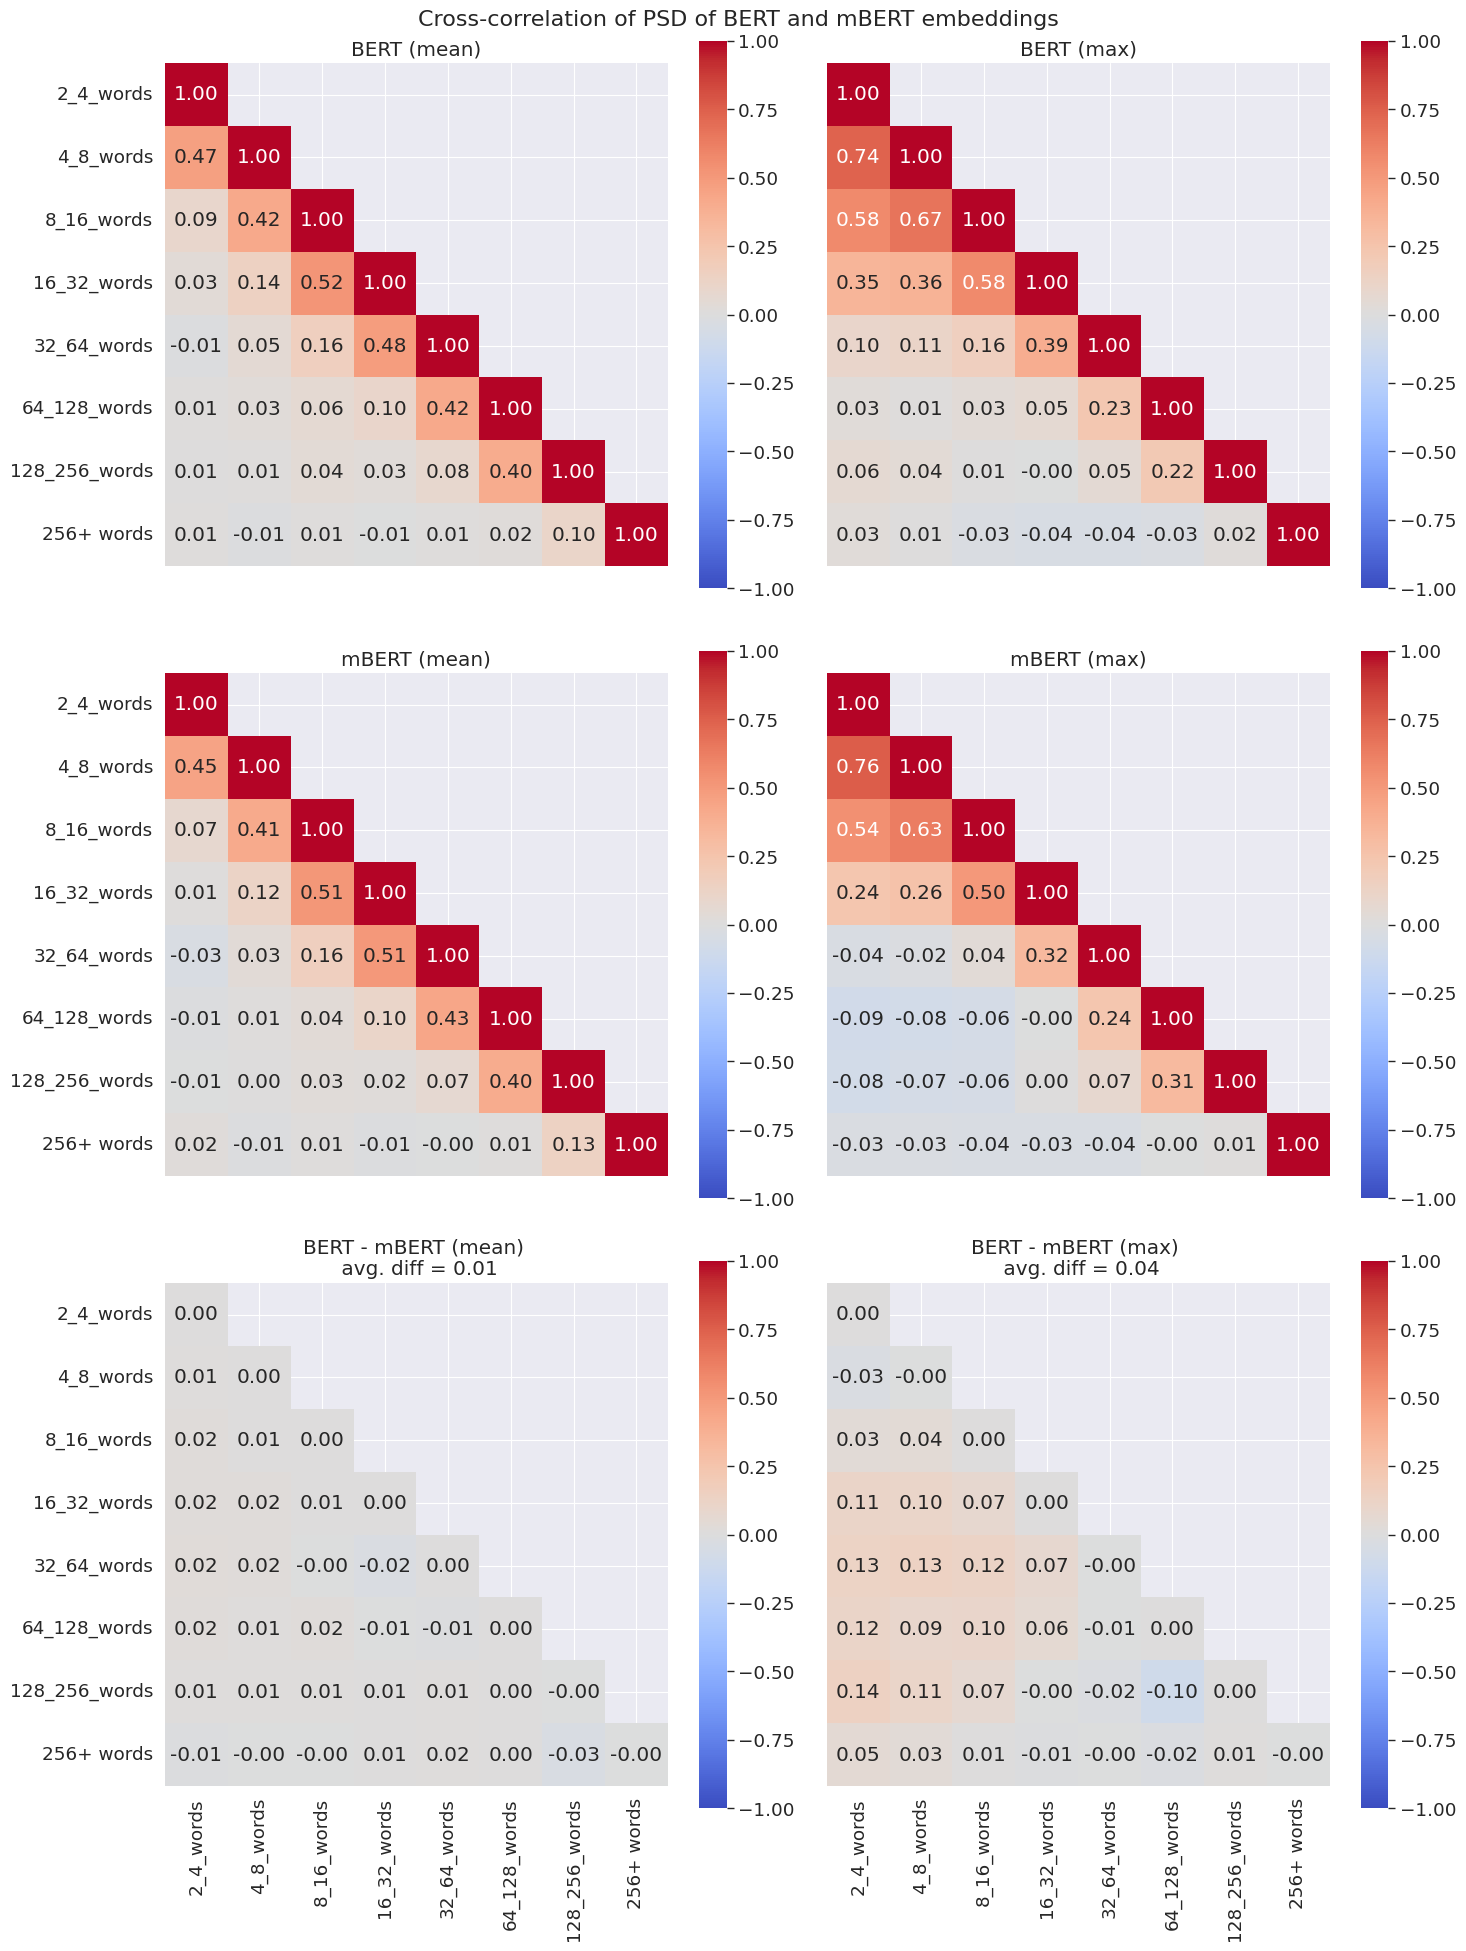

In [27]:
# plot heatmap of cross-correlation

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20), sharey=True, sharex=True)
axes = axes.ravel()

plot_heatmap(bert_crosscorr_mean, periods, ax=axes[0])
plot_heatmap(bert_crosscorr_max, periods, ax=axes[1])
plot_heatmap(mbert_crosscorr_mean, periods, ax=axes[2])
plot_heatmap(mbert_crosscorr_max, periods, ax=axes[3])
plot_heatmap(diff_crosscorr_mean, periods, ax=axes[4])
plot_heatmap(diff_crosscorr_max, periods, ax=axes[5])

axes[0].set_title("BERT (mean)")
axes[1].set_title("BERT (max)")
axes[2].set_title("mBERT (mean)")
axes[3].set_title("mBERT (max)")
axes[4].set_title(f"BERT - mBERT (mean) \n avg. diff = {mean_avg_diff:.2f}")
axes[5].set_title(f"BERT - mBERT (max) \n avg. diff = {max_avg_diff:.2f}")

# # add rotation to xticklabels
# for ax in axes[4:]:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right") 

fig.suptitle("Cross-correlation of PSD of BERT and mBERT embeddings", fontsize=16)

plt.tight_layout()
plt.show()

# Cross-correlation across Models


In [28]:
def compute_timescale_crosscorrelation_models(feature_set_1, feature_set_2, periods, agg_method="mean"):
    """
    Compute the cross-correlation of the PSD of a feature set for a given timescale.

    Parameters
    ----------
    feature_set : Dict
        Dictionary containing the feature set.
    periods : list
        List of timescales of the feature set.
    agg_method : str
        Aggregation method to use. Options are 'mean', 'max' or 'min'.

    Returns
    -------
    crosscorr : np.ndarray
        Cross-correlation of the PSD of the feature set for the given timescale.
    """
    
    # aggregating over all features
    feature_1 = []
    feature_2 = []

    for p in periods:
        if agg_method == "max":
            f1 = np.max(feature_set_1[p], axis=1)
            f2 = np.max(feature_set_2[p], axis=1)
        elif agg_method == "min":
            f1 = np.min(feature_set_1[p], axis=1)
            f2 = np.min(feature_set_2[p], axis=1)    
        else:  # agg_method == 'mean':
            f1 = np.mean(feature_set_1[p], axis=1)
            f2 = np.mean(feature_set_2[p], axis=1)

        feature_1.append(f1)
        feature_2.append(f2)

    # stack em up
    feature_1 = np.vstack(feature_1)
    feature_2 = np.vstack(feature_2)

    # now join the two feature sets
    features = np.vstack([feature_1, feature_2])


    # compute cross-correlation across timescales
    crosscorr = np.corrcoef(features)

    # take only the upper right corner
    crosscorr = crosscorr[len(periods):, :len(periods)]
    return crosscorr

In [29]:
crosscorr_mean = compute_timescale_crosscorrelation_models(bert_train_feature, mbert_train_feature, periods, agg_method="mean")
crosscorr_max = compute_timescale_crosscorrelation_models(bert_train_feature, mbert_train_feature, periods, agg_method="max")

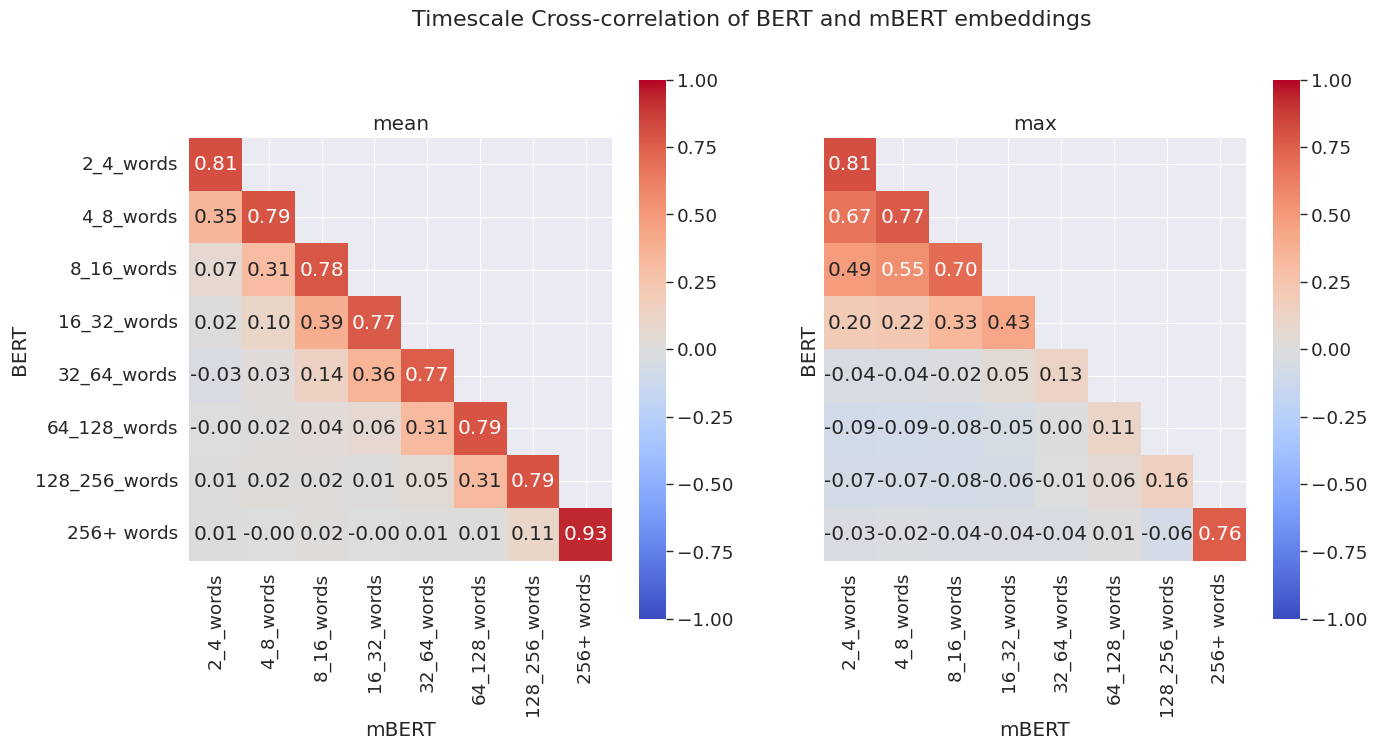

In [30]:
# plot heatmap 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.ravel()

plot_heatmap(crosscorr_mean, periods, ax=axes[0])
plot_heatmap(crosscorr_max, periods, ax=axes[1])

axes[0].set_title("mean")
axes[0].set_ylabel("BERT")
axes[0].set_xlabel("mBERT")


axes[1].set_title("max")
axes[1].set_ylabel("BERT")
axes[1].set_xlabel("mBERT")

fig.suptitle("Timescale Cross-correlation of BERT and mBERT embeddings", fontsize=16)

plt.show()